In [28]:
from os import path
import sys

# Third-party
import astropy.coordinates as coord
import astropy.table as at
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.optimize import minimize

import emcee
from pyia import GaiaData
import schwimmbad

import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics import mockstream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph

## Prepare data:

In [29]:
tbl = at.Table.read('/Users/apricewhelan/projects/gd1-dr2/output/rrl_bhb_bs_rgb_master.fits')

g = GaiaData(tbl)

rv = tbl['rv'].copy()
rv[~np.isfinite(rv)] = 0.

c = coord.SkyCoord(ra=tbl['ra']*u.deg, 
                   dec=tbl['dec']*u.deg,
                   distance=coord.Distance(distmod=tbl['DM']),
                   pm_ra_cosdec=tbl['pmra']*u.mas/u.yr,
                   pm_dec=tbl['pmdec']*u.mas/u.yr,
                   radial_velocity=rv*u.km/u.s)
c_gd1 = c.transform_to(gc.GD1)

# Only take stars with phi1 > -80
phi1_mask = c_gd1.phi1.wrap_at(180*u.deg) > -80*u.deg
c_gd1 = c_gd1[phi1_mask]
c = c[phi1_mask]
g = g[phi1_mask]
rv = rv[phi1_mask]
tbl = tbl[phi1_mask]

/Users/apricewhelan/projects/astropy/astropy/coordinates/angles.py:522: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/apricewhelan/projects/astropy/astropy/coordinates/angles.py:522: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/apricewhelan/projects/astropy/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [30]:
cov_gd1 = gc.transform_pm_cov(c, g.get_cov()[:, 3:5, 3:5], gc.GD1)

In [31]:
dist = coord.Distance(distmod=np.random.normal(tbl['DM'], tbl['DM_error'], 
                                               size=(10000, len(tbl))))

In [32]:
data = at.Table()

data['phi1'] = c_gd1.phi1.wrap_at(180*u.deg)

data['phi2'] = c_gd1.phi2
data['phi2_error'] = (1*u.mas).to(u.deg)

data['distance'] = np.nanmean(dist, axis=0).to(u.kpc)
data['distance_error'] = np.nanstd(dist.view(u.Quantity).to(u.kpc), axis=0)
data['distance_error'][~np.isfinite(data['distance_error'])] = np.inf

pm_unit = c_gd1.pm_phi1_cosphi2.unit
data['pm_phi1_cosphi2'] = c_gd1.pm_phi1_cosphi2
data['pm_phi1_cosphi2_ivar'] = 1 / (cov_gd1[:, 0, 0] * pm_unit**2)

data['pm_phi2'] = c_gd1.pm_phi2
data['pm_phi2_ivar'] = 1 / (cov_gd1[:, 1, 1] * pm_unit**2)

data['radial_velocity'] = tbl['rv'] * u.km/u.s
data['radial_velocity'][np.isnan(data['radial_velocity'])] = 0.
data['radial_velocity_error'] = tbl['rv_error'] * u.km/u.s
data['radial_velocity_error'][np.isnan(data['radial_velocity_error'])] = np.inf

data = data.filled(fill_value=0)

---

In [97]:
class MockStreamFitter:
    
    def __init__(self, data, stream_frame, progenitor_potential, 
                 potential_cls=None, galcen_frame=None, 
                 mockstream_run_kwargs=None, frozen=None, 
                 lon0=0*u.deg, lon_bins=None):
        
        # First validate the stream coordinate frame, because we use this to 
        # check the input data to make sure the component names match:
        if not isinstance(stream_frame, coord.BaseCoordinateFrame):
            raise TypeError('Invalid stream frame input: this must be an '
                            'astropy frame class *instance*.')

        self.stream_frame = stream_frame
        self._frame_comp_names = (
            list(stream_frame.get_representation_component_names().keys()) +
            list(stream_frame.get_representation_component_names('s').keys()))
        self._frame_attrs = stream_frame.frame_attributes
        
        # Validate the input data: the data must provide sky position, distance 
        # (not distmod!), proper motions, and radial velocity for stars.
        # TODO: we should also support distance modulus?
        self.data = at.QTable(data, copy=False)  # keep the original data table
        self._data = at.Table()  # a copy with units stripped
        self._data_units = dict()
        self._has_data = dict()  # what data was provided
        for i, name in enumerate(self._frame_comp_names):
            self._has_data[name] = name in self.data.colnames

            if self._has_data[name]:
                self._data_units[name] = self.data[name].unit
                self._data[name] = self.data[name].value
                
                if name == self._frame_comp_names[0]:
                    # skip error/ivar parsing for longitude data
                    continue
                    
                if (f'{name}_ivar' not in self.data.colnames and 
                        f'{name}_error' not in self.data.colnames):
                    warn(f"No uncertainties provided for component '{name}'"
                         "- if you want to provide uncertainties, you must "
                         "pass in error values with the column name "
                         f"'{name}_error' or inverse-variance values with "
                         f"column name '{name}_ivar' in the input table.",
                         RuntimeWarning)
                    self._data[name + '_ivar'] = np.zeros(len(self.data))
                    continue

                elif f'{name}_ivar' in self.data.colnames:
                    ivar_col = self.data[name + '_ivar']

                elif f'{name}_error' in self.data.colnames:
                    ivar_col = 1 / self.data[name + '_error']**2

                # ensure the ivar values are in the same units as the data
                ivar_unit = 1 / self._data_units[name] ** 2
                self._data[name + '_ivar'] = ivar_col.to_value(ivar_unit)

        # Units are auto-validated by quantity_input
        self.lon0 = lon0
        if lon_bins is None:
            lon_bins = np.arange(-180, 180+1e-3, 1.) * u.deg  # MAGIC NUMBER
        self.lon_bins = lon_bins

        # Strip units
        lon_name = self._frame_comp_names[0]
        self._lon0 = lon0.to_value(self._data_units[lon_name])
        self._lon_bins = lon_bins.to_value(self._data_units[lon_name])
        
        # Galactocentric frame
        if galcen_frame is None:
            with coord.galactocentric_frame_defaults.set('v4.0'):
                galcen_frame = coord.Galactocentric()
        else:
            if not isinstance(galcen_frame, coord.Galactocentric):
                raise ValueError("Input Galactocentric frame specification "
                                 "must be an astropy.coordinates "
                                 "Galactocentric() instance, not "
                                 f"'{type(galcen_frame)}'.")
        self.galcen_frame = galcen_frame
        
        # Frozen parameters:
        if frozen is None:
            frozen = dict()
        self.frozen = frozen
        
        # Set up the external potential:
        if isinstance(frozen.get('potential', None), gp.PotentialBase):
            # The whole potential is frozen, so we don't need to parse the cls
            self._potential = self.frozen.get('potential')
            
            if potential_cls is not None:
                raise ValueError("Pass in either a frozen potential instance, "
                                 "or potential class specification, not both")
        
        else:
            self._potential = None
            
            raise NotImplementedError("Only support frozen potential now")
            
            if isinstance(potential_cls, dict):
                # composite potential
                pass
            
            elif issubclass(potential_cls, gp.PotentialBase):
                pass
                potential_cls._physical_types
            
            else:
                raise ValueError("Unknown potential class type: "
                                 f"{type(potential_cls)}")
                
        # TODO: do the same for galactocentric frame?
                
        # TODO: do the same for the mock stream generation?
        self._df = gd.FardalStreamDF()
        self._progenitor_potential = progenitor_potential
        
        if mockstream_run_kwargs is None:
            raise ValueError("TODO")
        self._mockstream_run_kwargs = mockstream_run_kwargs

    def get_w0(self, **components):
        kw = dict()
        kw['phi1'] = self._lon0 * u.deg
        
        for k, v in components.items():
            # TODO: this will fail if there are missing dimensions, because 
            # _data_units will be missing that key
            kw[k] = v * self._data_units[k]
        kw.update(self._frame_attrs)
        
        c = self.stream_frame.__class__(**kw)
        w0 = gd.PhaseSpacePosition(c.transform_to(self.galcen_frame).data)
        return w0

    def get_hamiltonian(self, **potential_pars):
        if self._potential is not None:
            # short-circuit: the entire potential is frozen
            H = gp.Hamiltonian(self._potential)
            
        else:
            if isinstance(self.potential_cls, dict):
                pot = gp.CCompositePotential()
                for k in self.potential_cls:
                    pot[k] = self.potential_cls[k](units=self.potential_units,
                                                   **potential_pars[k])
            else:
                pot = self.potential_cls(units=self.potential_units,
                                         **potential_pars)
            H = gp.Hamiltonian(pot)
            
        return H
    
    def generate_mockstream(self, H, w0):
        gen = gd.MockStreamGenerator(
            df=self._df, hamiltonian=H, 
            progenitor_potential=self._progenitor_potential)
        
        stream = gen.run(w0, 
                         prog_mass=self._progenitor_potential.parameters['m'], 
                         **self._mockstream_run_kwargs)
        
        return stream
    
    def ln_likelihood(self, par_dict):
        w0 = self.get_w0(galcen_frame, **par_dict.get('w0', {}))
        H = self.get_hamiltonian(**par_dict.get('potential', {}))

        stream = self.get_mockstream(H, orbit)
        if stream is None:
            return -np.inf

        return self.tracks_ln_likelihood(stream, galcen_frame)

In [221]:
fitter = MockStreamFitter(data=data, stream_frame=gc.GD1Koposov10(),
                          progenitor_potential=gp.PlummerPotential(m=1.5e4*u.Msun, 
                                                                   b=5*u.pc,
                                                                   units=galactic),
                          mockstream_run_kwargs=dict(dt=-1*u.Myr, n_steps=6000, 
                                                     n_particles=1),
                          frozen={'potential': gp.MilkyWayPotential(
                              halo={'m': 6e11, 'r_s': 16, 'c': 1.25})},
                          lon0=0*u.deg)

In [222]:
w0 = fitter.get_w0(**{'phi2': -1,
  'distance': 10.1,
  'pm_phi1_cosphi2': -9,
  'pm_phi2': -1.95,
  'radial_velocity': -280})

In [223]:
stream, orbit = fitter.generate_mockstream(fitter.get_hamiltonian(), w0)

In [224]:
stream_c = stream.to_coord_frame(fitter.stream_frame, 
                                 galactocentric_frame=fitter.galcen_frame)

(5, 15)

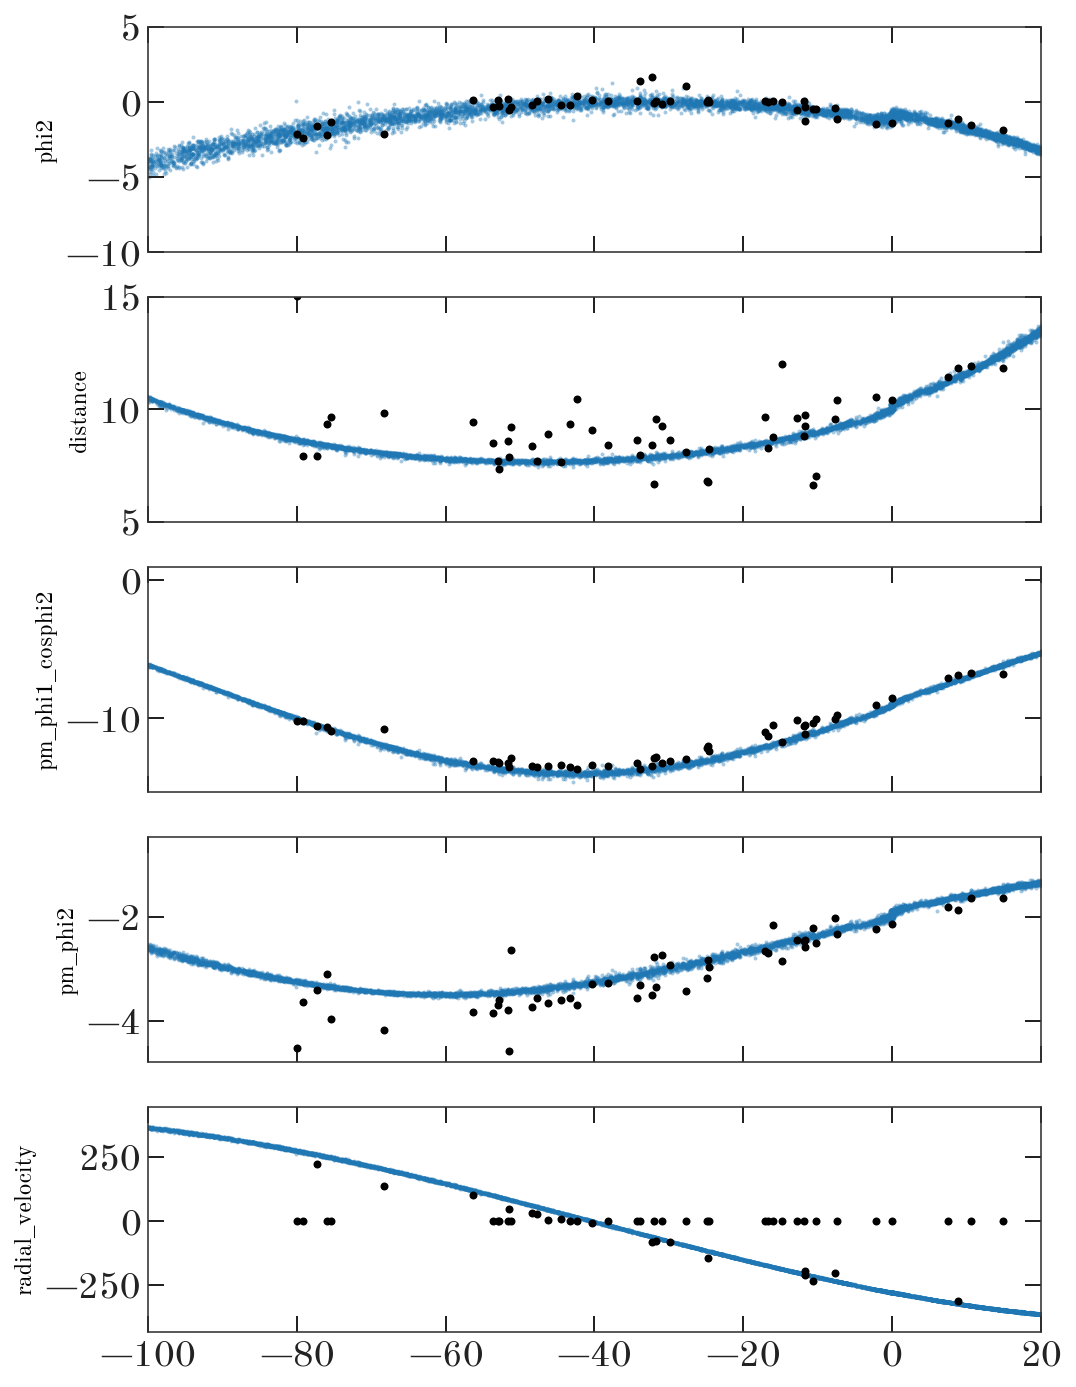

In [225]:
fig, axes = plt.subplots(5, 1, figsize=(8, 12), 
                         sharex=True)

for i, name in enumerate(fitter._frame_comp_names[1:]):
    ax = axes[i]
    
    ax.plot(fitter.data['phi1'], fitter.data[name], 
            marker='o', ls='none', color='k', ms=4)
    
    ax.plot(stream_c.phi1.wrap_at(180*u.deg).degree,
            getattr(stream_c, name).value, 
            marker='o', ls='none', color='tab:blue', ms=2, alpha=0.4, zorder=-100)
    ax.set_ylabel(name, fontsize=12)
    
ax.set_xlim(-100, 20)
axes[0].set_ylim(-10, 5)
axes[1].set_ylim(5, 15)

In [226]:
test = at.Table.read('/Users/apricewhelan/projects/gd1-dr2/data/gd1-better-selection.fits')
mask = test['sliding_gi_cmd_mask'] & test['sliding_pm_mask'] & (test['stream_prob'] > 0.5)
test = test[mask]

In [227]:
n_data = ((test['phi1'] > -60) & (test['phi1'] < -20)).sum()
n_model = ((stream_c.phi1.degree > -60) & (stream_c.phi1.degree < -20)).sum()

In [228]:
idx = np.random.choice(len(stream_c), size=int(len(stream_c) * n_data/n_model), 
                       replace=False)

(-4, 2)

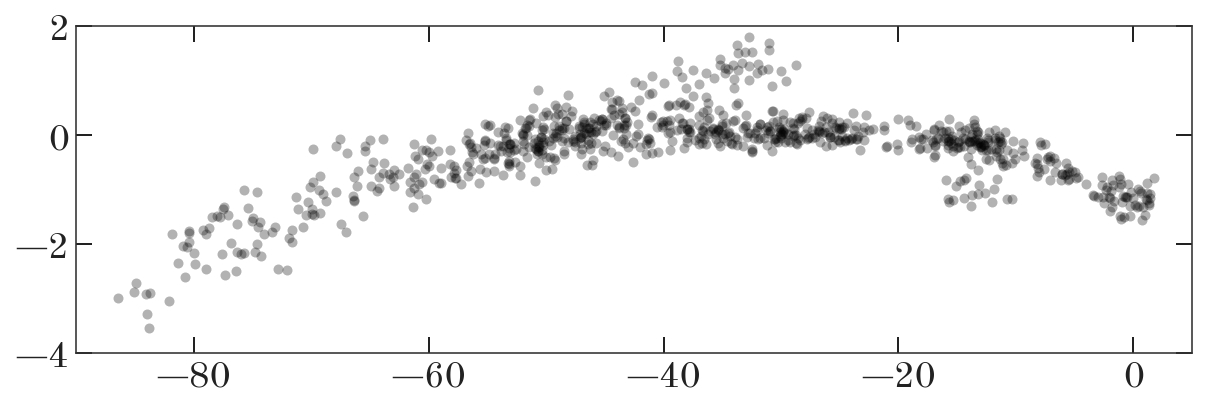

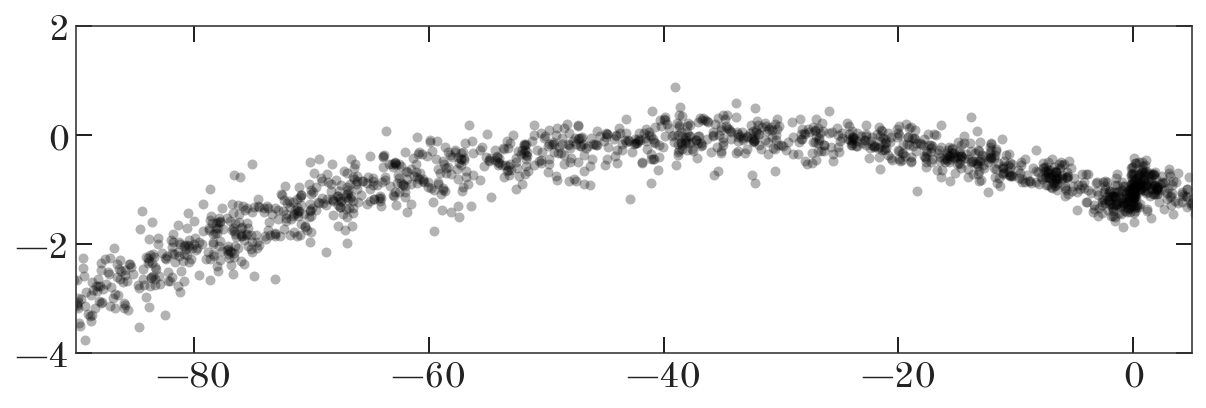

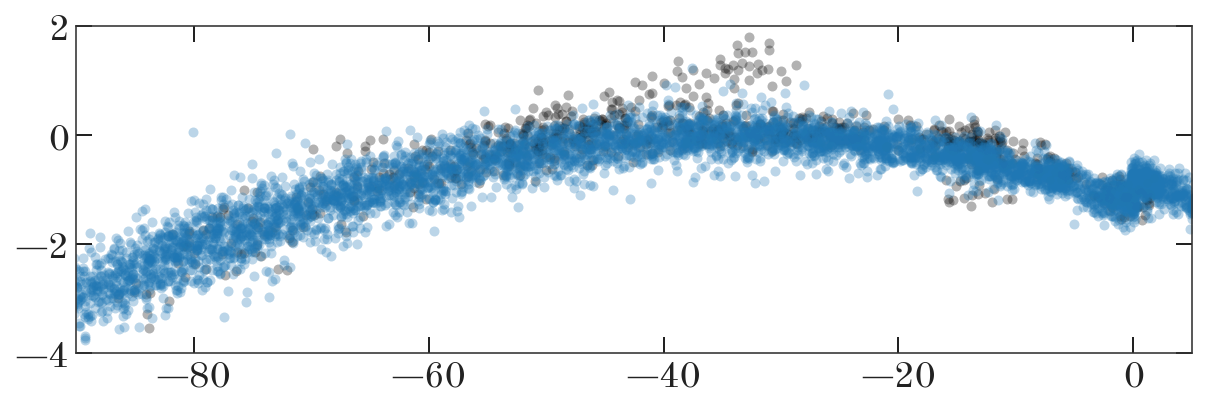

In [230]:
plt.figure(figsize=(10, 3))
plt.scatter(test['phi1'], test['phi2'], alpha=0.3, lw=0)
plt.xlim(-90, 5)
plt.ylim(-4, 2)

# ---

plt.figure(figsize=(10, 3))
plt.scatter(stream_c.phi1.wrap_at(180*u.deg).degree[idx],
            stream_c.phi2.degree[idx], alpha=0.3, lw=0)
plt.xlim(-90, 5)
plt.ylim(-4, 2)

# --

plt.figure(figsize=(10, 3))
plt.scatter(test['phi1'], test['phi2'], alpha=0.3, lw=0)
plt.scatter(stream_c.phi1.wrap_at(180*u.deg).degree,
            stream_c.phi2.degree, alpha=0.3, lw=0)
plt.xlim(-90, 5)
plt.ylim(-4, 2)

In [235]:
fitter._potential.save('../spur-hacks/potential.yml')

In [244]:
f = w0.to_hdf5('../spur-hacks/w0.hdf5')
f.close()

/Users/apricewhelan/projects/gala/gala/dynamics/core.py:557: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(f)


In [239]:
import pickle

In [241]:
with open('../spur-hacks/galcen.pkl', 'wb') as f:
    pickle.dump(fitter.galcen_frame, f)